In [1]:
import jax 
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import model_jax as model

In [4]:
import optax

In [5]:
from flax import linen as nn
from flax.training import train_state

In [66]:
key0, key1 = random.split(key=random.PRNGKey(1), num=2)

In [67]:
train_test =  jnp.asarray(random.normal(key0, (100, 1, 40)))

In [68]:
@jax.jit
def loss_fn(params, state, inputs, target, mu_filter, sigma_filter, w_filter):
    predicts = state.apply_fn(params, inputs)
    mu_predict = jnp.matmul(predicts, mu_filter)
    sigma_predict = jnp.matmul(predicts, sigma_filter)
    w_predict = jnp.matmul(predicts, w_filter)

    mu_target = jnp.matmul(target, mu_filter)
    sigma_target = jnp.matmul(target, sigma_filter)
    w_target = jnp.matmul(target, w_filter)

    mu_diff = mu_predict - mu_target
    sigma_diff = (sigma_predict - sigma_target)/4


    loss = jnp.mean(w_target * (mu_diff**2 / sigma_predict + (jnp.exp(sigma_diff) - jnp.exp(-sigma_diff))**2)) + jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10))) 

    #loss = optax.l2_loss(predicts, target).mean()
    return loss

@jax.jit
def train_step(state, inputs, target, mu_filter, sigma_filter, w_filter):
    loss, grad = jax.value_and_grad(loss_fn)(state.params, state, inputs, target, mu_filter, sigma_filter, w_filter)
    #updates, new_state = state.tx.update(grad, state)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

#@jax.jit 
def sample_batch(batch, sample_size, rng):
    num_samples = batch.shape[0]
    if sample_size > num_samples:
        sample_size = num_samples
    indices = jax.random.choice(rng, num_samples, shape=(sample_size,), replace=False)
    sampled_batch = batch[indices,:,:]
    return sampled_batch

In [10]:
csv_file = 'datas/input_32768_e15_K5_style2_1.csv'
df = pd.read_csv(csv_file)
data = jnp.transpose(jnp.array(df.values),[1,0])
print(data.shape)

input_data = data.reshape(data.shape[0], 1, data.shape[1])
print(input_data.shape)

(32768, 40)
(32768, 1, 40)


In [11]:
csv_file = 'datas/target_32768_e15_K5_style2_1.csv'
df = pd.read_csv(csv_file)
data = jnp.transpose(jnp.array(df.values),[1,0])
print(data.shape)

target_data = data.reshape(data.shape[0], 1, data.shape[1])
print(target_data.shape)

(32768, 15)
(32768, 1, 15)


In [12]:
n_gauss = 5
num_classes = 3*n_gauss

In [71]:
heads = 3
d_model = 40
n_layer = 12
var = model.TransformerEncoder(n_gauss, heads, d_model, n_layer).init(key1, train_test)
#state = train_state.TrainState.create(apply_fn=model.TransformerEncoder(n_gauss, heads, d_model, n_layer).apply, params=var, tx=optax.chain(optax.scale_by_adam(), optax.scale_by_learning_rate(optax.piecewise_constant_schedule(init_value=1e-3, boundaries_and_scales={1000: 0.3}))))
state = train_state.TrainState.create(apply_fn=model.TransformerEncoder(n_gauss, heads, d_model, n_layer).apply, params=var, tx=optax.chain(optax.scale_by_adam(), optax.scale_by_learning_rate(optax.exponential_decay(1e-4, 2000, 0.3))))

In [14]:
indices_m = jnp.array(range(0, n_gauss))
mu_filter = (jnp.eye(num_classes)[indices_m]).transpose()

indice_s = jnp.array(range(n_gauss, 2*n_gauss))
sigma_filter = (jnp.eye(num_classes)[indice_s]).transpose()

indice_w = jnp.array(range(2*n_gauss, 3*n_gauss))
w_filter = (jnp.eye(num_classes)[indice_w]).transpose()
print(w_filter)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


step: 2000, loss: 3.1204376220703125
step: 4000, loss: 1.4007846117019653
step: 6000, loss: 1.1502846479415894
step: 8000, loss: 1.0984394550323486
step: 10000, loss: 1.02698814868927
step: 12000, loss: 1.017311453819275
step: 14000, loss: 1.0109211206436157
step: 16000, loss: 1.0079233646392822
step: 18000, loss: 1.0068368911743164
step: 20000, loss: 1.0065221786499023
step: 22000, loss: 1.006485939025879
step: 24000, loss: 1.0064888000488281
step: 26000, loss: 1.0064784288406372
step: 28000, loss: 1.0066049098968506
step: 30000, loss: 1.0064674615859985
step: 32000, loss: 1.0065935850143433
step: 34000, loss: 1.0065937042236328
step: 36000, loss: 1.0065937042236328
step: 38000, loss: 1.0065937042236328
step: 40000, loss: 1.0065937042236328


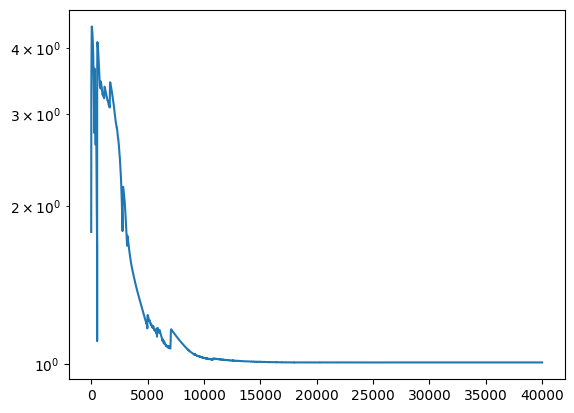

In [72]:
loss_hist = []
for step in range(1, 16001):
    sample_input = sample_batch(input_data, 4096, key0)
    sample_target = sample_batch(target_data, 4096, key0)
    state, loss = train_step(state, sample_input, sample_target, mu_filter, sigma_filter, w_filter)
    loss_hist.append(loss)
    if step % 2000 == 0:
        print(f'step: {step}, loss: {loss}')

plt.semilogy(loss_hist, label='loss')

In [74]:
it = 102
print(state.apply_fn(state.params, input_data[it:it+1,:,:]))
print(target_data[it:it+1,:,:])

[[[-0.4374482  -0.9958357  -0.07876232  0.2741677   0.51665014
    0.7162397  -1.5730875   1.6256926   1.9061357   0.9702001
    0.8004032   0.05434242  0.01940913  0.02620612  0.09963915]]]
[[[-3.5252950e-01 -6.2133265e-01 -2.9643309e-01  3.3991697e-01
    7.1397007e-01 -2.8844132e+00 -3.2838550e+00 -2.6919932e+00
    1.9851236e+00 -3.4980578e+00  5.7956249e-01  2.5702325e-01
    6.7364150e-03  3.3841657e-03  1.5329370e-01]]]
